In [1]:
"""
ARX Estimation - # State Space Model

@author: Jeferson Gallego Chaverra
"""

from sympy import MatrixSymbol, Matrix, Identity
import sympy as sym
sym.init_printing()
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import control as cl

def validar_Dato(frase):

    while True:
            valor= input(frase)     
            if valor.isnumeric():
                valor = int(valor)
                break
            else:
                print('El dato ingresado no es numerico , por favor ingresar un dato numerico')

    return valor

def limites(frase,minimo,maximo):    
    flag=True
    while flag:
        y=validar_Dato(frase)
        if y<=maximo and y>=minimo:
            flag=False
        else:
            print(f'El dato ingresado esta por fuera de los limites establecidos min {minimo} y max {maximo}')

    return y


## Model
$$A = \begin{bmatrix}-2&-10\\1&0\end{bmatrix}$$
$$B = \begin{bmatrix}1&0\end{bmatrix}, C = \begin{bmatrix}0&10\end{bmatrix}, D = 0$$


## Simulation

100


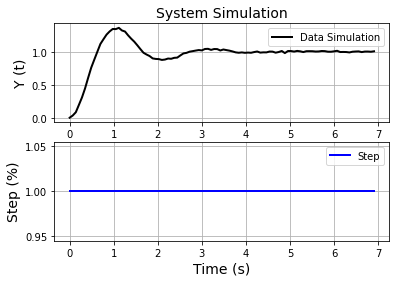

In [2]:
# State Space Model
A = [[-2, -10],[1, 0]]
B = [1, 0]
C = [0, 10]
D = [0]

# Model Representation 
g = cl.StateSpace(A, B, C, D)

# Step Response
t,y = cl.step_response(g) 
N = len(y)
u = np.ones(N)
dt = t[1]-t[0]

# Noise
r = 0.01
e = np.random.normal(0,r,size=N)
yn = y+e

# Plot
ax=plt.subplot(2,1,1)
ax.grid()
plt.title("System Simulation",fontsize = 14)
plt.plot(t, yn, 'k', linewidth=2, label='Data Simulation')
plt.ylabel('Y (t)', fontsize = 14)
plt.legend(loc='best')
            
ax=plt.subplot(2,1,2)
ax.grid()
plt.plot(t, u, 'b-', linewidth=2, label='Step')
plt.ylabel('Step (%)', fontsize = 14)
plt.xlabel('Time (s)', fontsize = 14)
plt.legend(loc='best')
print(len(yn))
plt.show()

## Model Ge
$$G_e(z) = \frac{B(z)}{A(z)}$$
$$(1) = \frac{b_1z^{-1}+b_2z^{-2}}{1+a_1z^{-1}+a_{2}z^{-2}}$$
$$(2) = \frac{b_1z^{-1}}{1+a_1z^{-1}+a_{2}z^{-2}}$$
$$(3) = \frac{b_1z^{-1}}{1+a_1z^{-1}}$$
$$(4) = \frac{b_1z^{-1}+b_2z^{-2}}{1+a_1z^{-1}}$$

In [3]:
# Vectors of States
y_1 = np.zeros(N)
y_2 = np.zeros(N)
u_1 = np.zeros(N)
u_2 = np.zeros(N)
x=0
    
for k in range(1,N):
    y_1[k]=yn[k-1]
    u_1[k]=u[k-1]
for k in range(2,N):
    y_2[k]=yn[k-2]
    u_2[k]=u[k-2]

 


## $\phi$ 

In [4]:

x =limites('Ingrese Tipo de Ge',1,4)

## Phi Vector
if x==1:
        phi = np.array([-y_1,-y_2,u_1,u_2]).transpose()
elif x == 2:
        phi = np.array([-y_1,-y_2,u_1,]).transpose()
elif x == 3:
      phi = np.array([-y_1,u_1,]).transpose()
elif x == 4:
      phi = np.array([-y_1,u_1,u_2]).transpose()   

##  $\theta$

$$ \theta = (\theta^{T}\theta)^{-1} \theta^{T} yn 


In [5]:
alpha = 0.8
A = np.dot(phi.T,phi) + alpha*np.eye(len(np.dot(phi.T,phi)))
theta = np.dot(np.linalg.inv(A),np.dot(phi.T,yn))
theta

array([-0.47575774, -0.31383382,  0.0805256 ,  0.1370419 ])

## Polinomial
## Transfer Function
$$G_e(z) = \frac{B(z)}{A(z)}$$

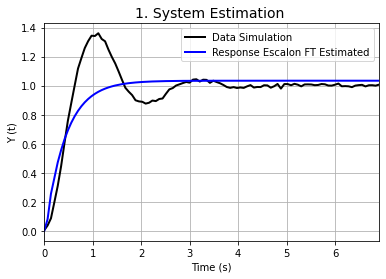

In [6]:
z = sym.symbols('z', complex=True) # z=Simbolo

# Polinomial B(z) / A(z)

if x==1:
       A = 1 + theta[0]*z**-1 + theta[1]*z**-2  
       B = theta[2]*z**-1 + theta[3]*z**-2
elif x == 2:
       A = 1 + theta[0]*z**-1 + theta[1]*z**-2  
       B = theta[2]*z**-1
elif x == 3:
       A = 1 + theta[0]*z**-1
       B = theta[1]*z**-1
elif x ==4:
       A = 1 + theta[0]*z**-1 
       B = theta[1]*z**-1 + theta[2]*z**-2

G = B/A
G = G.simplify()

# Transfer Function Estimation

if x==1:
       #G_1
       G_e = cl.tf([theta[2], theta[3]],[1, theta[0], theta[1]],dt) 
elif x == 2:
       #G_1
       G_e = cl.tf([theta[2]],[1, theta[0], theta[1]],dt)
elif x == 3:
       #G_3
       G_e = cl.tf([theta[1]],[1, theta[0],],dt) 
elif x ==4:
       #G_4
       G_e = cl.tf([theta[1], theta[2]],[1, theta[0]],dt)
 
# Step Response
td,ye = cl.step_response(G_e)

# ECM FT
ECM = np.sqrt(np.dot((yn-ye[0:100]).transpose(),(yn-ye[0:100])))/len(yn)

plt.plot(t,yn,'k', linewidth=2, label='Data Simulation')
plt.plot(td,ye, 'b-', linewidth=2, label='Response Escalon FT Estimated')
plt.xlim([0, t[len(t)-1]])
plt.title("1. System Estimation ",fontsize = 14)
plt.ylabel('Y (t)')
plt.xlabel('Time (s)')
plt.legend(loc= 'best')
plt.grid()
plt.show()

In [7]:
## FT  Estimated 
print(G_e )
print(ECM)


   0.08053 z + 0.137
-----------------------
z^2 - 0.4758 z - 0.3138

dt = 0.06977530584830444

0.013301800921589925


## Y_r [k]

$$y_e[k] = (1 - A)*y[k] + B*u[k]$$

$$(1) = y_e[k] = - a_1*y[k-1] - a_2*y[k-2] + b_1*u[k-1] + b_2*u[k-2]$$
$$(2) = y_e[k] = - a_1*y[k-1] - a_2*y[k-2] + b_1*u[k-1]$$
$$(3) = y_e[k] = - a_1*y[k-1] + b_1*u[k-1]$$
$$(4) = y_e[k] = - a_1*y[k-1] + b_1*u[k-1] + b_2*u[k-2]$$

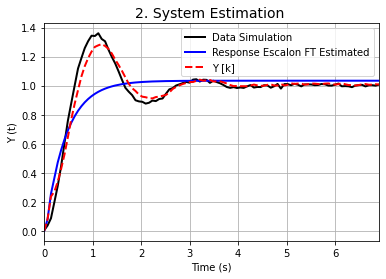

0.004584894783418706


In [8]:
# Response Y[K]=  Estimated Response

if x==1:
       #G_1
       yr = -theta[0]*y_1-theta[1]*y_2+theta[2]*u_1+theta[3]*u_2
elif x == 2:
       #G_2
       yr = -theta[0]*y_1-theta[1]*y_2+theta[2]*u_1
elif x == 3:
       #G_3
       yr = -theta[0]*y_1+theta[1]*u_1
elif x ==4:
       #G_4
       yr = -theta[0]*y_1+theta[1]*u_1+theta[2]*u_2

# ECM Yr
ECM = np.sqrt(np.dot((yn[0:len(yr)]-yr[0:len(yr)]).transpose(),(yn[0:len(yr)]-yr[0:len(yr)])))/len(yr)

# Plot
plt.plot(t,yn,'k', linewidth=2, label='Data Simulation')
plt.plot(td,ye, 'b-', linewidth=2, label='Response Escalon FT Estimated')
plt.plot(t,yr, 'r--', linewidth=2, label='Y [k]')
plt.xlim([0, t[len(t)-1]])
plt.title("2. System Estimation ",fontsize = 14)
plt.ylabel('Y (t)')
plt.xlabel('Time (s)')
plt.legend(loc= 'best')
plt.grid()
plt.show()
print(ECM)